# Exploratory Data Analysis
## Context-Enriched Named Entity Recognition (NER) for Identifying Emerging Trends in Video Comments

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
!pip3 install wordcloud
from wordcloud import WordCloud
from collections import Counter
import ast
import itertools
import nltk
nltk.download('punkt')  # Download tokenizer models if not already done

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michelledavies/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Exploring the Data

In [2]:
# Importing the dataset
dataset = pd.read_excel('../data/4698969/Dataset.xlsx')
dataset

,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety
0,UghhPYDEB6B173gCoAEC,2017-04-28T18:12:45Z,Aaron Brown,1679,30,i want what he's smoking,spam,neutral,False,False,False,false
1,Ugh6WAPQinruAHgCoAEC,2017-04-28T18:15:14Z,Felician Cadar,684,22,I love how Musk always makes seemingly wild cl...,spam,positive,False,False,False,false
2,Ugj9xobHmVeDEHgCoAEC,2017-04-28T18:24:53Z,Kelvin Yang,0,0,No.3,spam,neutral,False,False,False,false
3,Ugj39PRg5dVn8XgCoAEC,2017-04-28T18:25:31Z,Kelvin Yang,140,4,Could be the start of a historical company,spam,neutral,False,False,False,false
4,Ugiu9jMmiWts1HgCoAEC,2017-04-28T18:31:52Z,serendipity42,675,9,Gotta start somewhere before making tunnels on...,spam,neutral,False,False,False,false
...,...,...,...,...,...,...,...,...,...,...,...,...
4395,UgzCzcQ7ZuMJjXEC3yp4AaABAg,NaN,María Lucía Suarez Barbery,0,0,im scared,spam,negative,False,False,False,false
4396,UgzMkHfSQ2GfByyql_t4AaABAg,NaN,Jack,0,1,Isn’t that just a train?,spam,neutral,False,False,False,false
4397,UgzSEcMR7cqbRiBtKi94AaABAg,NaN,Jason Goodacre,0,0,The Victorians had this idea over 100 years ag...,spam,neutral,False,False,False,false
4398,UgzSQv_tJ6cZKJ915uN4AaABAg,NaN,10k sub no video,0,0,Without searching \nThis pops up in my suggest...,spam,neutral,False,False,False,false


In [3]:
print("Columns in the dataset:", dataset.columns.tolist())

Columns in the dataset: ['ID', 'Date', 'Author', 'Likes', 'Replies', 'Comment', 'Relevance', 'Polarity', 'Feature request', 'Problem report', 'Efficiency', 'Safety']


In [4]:
# Descriptive statistics
dataset.describe()

,Likes,Replies
count,4400.000000,4400.000000
mean,15.610227,0.506818
std,171.647500,3.356983
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,5103.000000,70.000000


In [5]:
# Check for missing values
dataset.isnull().sum()

ID                   0
Date               125
Author               0
Likes                0
Replies              0
Comment              0
Relevance            0
Polarity             0
Feature request      0
Problem report       0
Efficiency           0
Safety               0
dtype: int64

### Analysis and Feature Engineering

In [6]:
# Define which columns are your labels
label_columns = ["Relevance", "Polarity", "Feature request", "Problem report", "Efficiency", "Safety"]

# Extract just the label columns
labels_dataset = dataset[label_columns]

# Display the first few rows of the label data
print(labels_dataset.head())

# Optional: Get unique label values for each label column (helpful for understanding the dataset)
unique_labels = {col: dataset[col].unique() for col in label_columns}
print("Unique labels in each column:")
for key, value in unique_labels.items():
    print(f"{key}: {value}")

  Relevance  Polarity  Feature request  Problem report  Efficiency Safety
0      spam   neutral            False           False       False  false
1      spam  positive            False           False       False  false
2      spam   neutral            False           False       False  false
3      spam   neutral            False           False       False  false
4      spam   neutral            False           False       False  false
Unique labels in each column:
Relevance: ['spam' 'ham']
Polarity: ['neutral' 'positive' 'negative']
Feature request: [False  True]
Problem report: [False  True]
Efficiency: [False  True]
Safety: ['false' 'true' ' ']


In [7]:
# If the "tokens" and "labels" columns are stored as string representations of lists, convert them:
def convert_to_list(x):
    try:
        return ast.literal_eval(x)
    except Exception:
        return x

# Tokenize the text in the 'Comment' column
dataset['tokens'] = dataset['Comment'].apply(nltk.word_tokenize)
dataset['tokens'] = dataset['tokens'].apply(convert_to_list)
# Convert each label column if they're stored as string representations of lists
for col in label_columns:
    dataset[col] = dataset[col].apply(convert_to_list)

# (Optional) Combine these label columns into a single multi-label column per row.
# This step depends on whether your downstream task expects a single column with a list of labels.
dataset['labels'] = dataset[label_columns].apply(lambda row: [row[col] for col in label_columns], axis=1)

In [8]:
dataset.head()

,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety,tokens,labels
0,UghhPYDEB6B173gCoAEC,2017-04-28T18:12:45Z,Aaron Brown,1679,30,i want what he's smoking,spam,neutral,False,False,False,false,"[i, want, what, he, 's, smoking]","[spam, neutral, False, False, False, false]"
1,Ugh6WAPQinruAHgCoAEC,2017-04-28T18:15:14Z,Felician Cadar,684,22,I love how Musk always makes seemingly wild cl...,spam,positive,False,False,False,false,"[I, love, how, Musk, always, makes, seemingly,...","[spam, positive, False, False, False, false]"
2,Ugj9xobHmVeDEHgCoAEC,2017-04-28T18:24:53Z,Kelvin Yang,0,0,No.3,spam,neutral,False,False,False,false,[No.3],"[spam, neutral, False, False, False, false]"
3,Ugj39PRg5dVn8XgCoAEC,2017-04-28T18:25:31Z,Kelvin Yang,140,4,Could be the start of a historical company,spam,neutral,False,False,False,false,"[Could, be, the, start, of, a, historical, com...","[spam, neutral, False, False, False, false]"
4,Ugiu9jMmiWts1HgCoAEC,2017-04-28T18:31:52Z,serendipity42,675,9,Gotta start somewhere before making tunnels on...,spam,neutral,False,False,False,false,"[Got, ta, start, somewhere, before, making, tu...","[spam, neutral, False, False, False, false]"


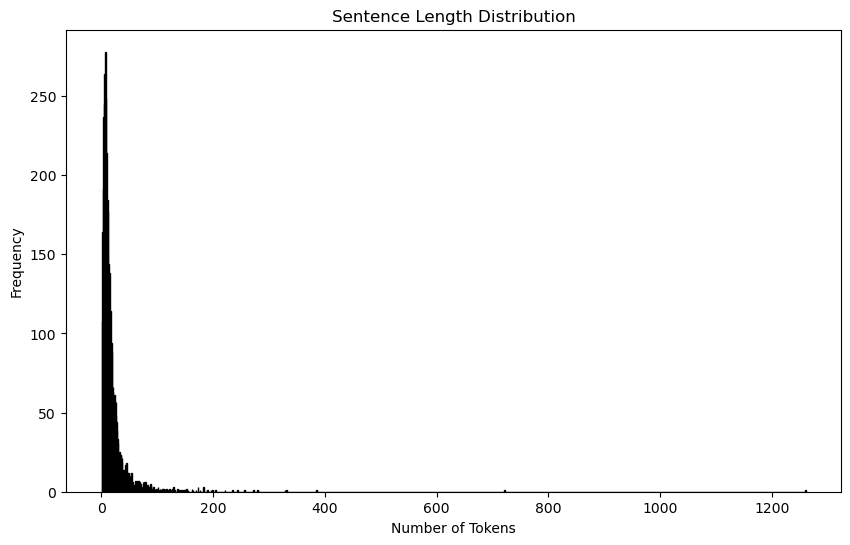

In [9]:
# -------------------------------------------
# EDA 1: Sentence Length Distribution
# -------------------------------------------
# Calculate the number of tokens per sentence.
dataset['num_tokens'] = dataset['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(dataset['num_tokens'], bins=range(0, max(dataset['num_tokens']) + 1, 1),
         color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

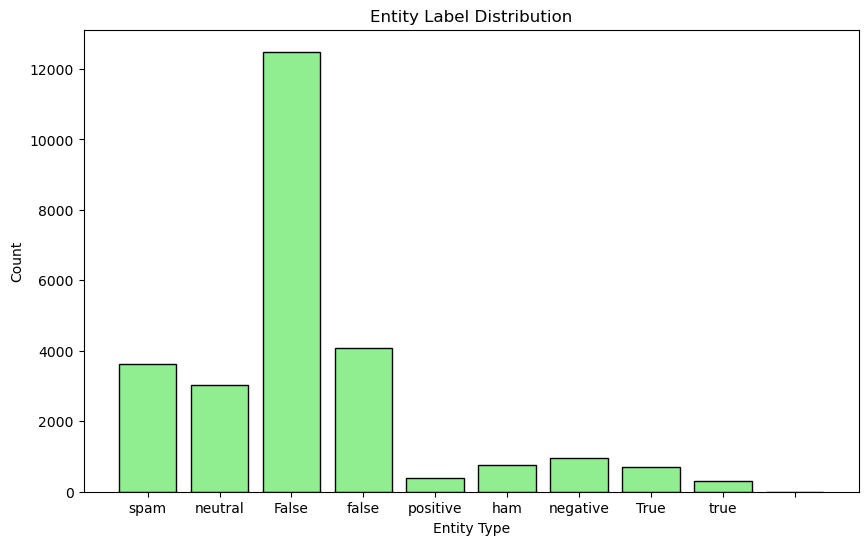

In [10]:
# -------------------------------------------
# EDA 2: Entity Label Distribution
# -------------------------------------------
# Flatten the list of labels for all sentences.
all_labels = [label for labels in dataset['labels'] for label in labels]

# For BIO formatted labels, remove the prefix (e.g., "B-PERSON" -> "PERSON")
def strip_bio(label):
    # Convert non-string labels to strings
    label = str(label)
    return label if label == "O" else label.split('-')[-1]

all_labels_clean = [strip_bio(label) for label in all_labels]

label_counts = Counter(all_labels_clean)
labels, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='lightgreen', edgecolor='black')
plt.title('Entity Label Distribution')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.show()

In [11]:
# -------------------------------------------
# EDA 3: Sentences with Entities vs. Without
# -------------------------------------------
# Determine if each sentence has at least one entity (i.e., label other than "O").
dataset['has_entity'] = dataset['labels'].apply(lambda labels: any(label != 'O' for label in labels))

num_sentences_with_entity = dataset['has_entity'].sum()
total_sentences = len(dataset)

print(f"Sentences with at least one entity: {num_sentences_with_entity} "
      f"({num_sentences_with_entity/total_sentences*100:.2f}%)")
print(f"Sentences with no entities: {total_sentences - num_sentences_with_entity} "
      f"({(total_sentences - num_sentences_with_entity)/total_sentences*100:.2f}%)")

Sentences with at least one entity: 4400 (100.00%)
Sentences with no entities: 0 (0.00%)


In [12]:
# -------------------------------------------
# EDA 4: Word Frequency Analysis
# -------------------------------------------
# Flatten all tokens from the dataset.
all_tokens = [token for tokens in dataset['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
most_common_tokens = token_counts.most_common(20)

print("Most common tokens:")
for token, count in most_common_tokens:
    print(f"{token}: {count}")

Most common tokens:
.: 2694
the: 2658
,: 1915
to: 1845
a: 1667
is: 1290
?: 1276
and: 1231
this: 1208
of: 1129
it: 986
in: 954
I: 937
be: 752
!: 748
that: 736
for: 707
you: 616
's: 559
car: 549


In [13]:
# -------------------------------------------
# EDA 5: Co-occurrence Analysis of Entity Types
# -------------------------------------------
# For each sentence, count co-occurrences of different entity types.
co_occurrence = Counter()

for labels in dataset['labels']:
    # Get the unique set of entity types in this sentence (ignoring non-entity tokens)
    entities = set([strip_bio(label) for label in labels if label != 'O'])
    # Count each unique pair combination (if more than one entity is present)
    for combo in itertools.combinations(entities, 2):
        co_occurrence[tuple(sorted(combo))] += 1

print("\nEntity co-occurrence counts (pairs found in the same sentence):")
for pair, count in co_occurrence.items():
    print(f"{pair}: {count}")


Entity co-occurrence counts (pairs found in the same sentence):
('neutral', 'spam'): 2486
('false', 'spam'): 3636
('False', 'spam'): 3636
('false', 'neutral'): 2827
('False', 'neutral'): 3023
('False', 'false'): 4076
('positive', 'spam'): 368
('false', 'positive'): 384
('False', 'positive'): 399
('False', 'negative'): 963
('True', 'negative'): 143
('ham', 'negative'): 185
('false', 'negative'): 876
('False', 'True'): 550
('False', 'ham'): 749
('True', 'ham'): 565
('True', 'false'): 351
('false', 'ham'): 451
('negative', 'true'): 91
('False', 'true'): 308
('True', 'true'): 213
('ham', 'true'): 312
('True', 'neutral'): 401
('ham', 'neutral'): 547
('negative', 'spam'): 782
('True', 'positive'): 21
('positive', 'true'): 16
('ham', 'positive'): 32
('neutral', 'true'): 205
(' ', 'neutral'): 1
(' ', 'False'): 1
(' ', 'True'): 1
(' ', 'ham'): 1


In [14]:
def token2features(sent, i):
    """
    Extracts features for a token at position i in the sentence.
    `sent` is a list of tokens (strings).
    """
    token = sent[i]
    
    features = {
        'bias': 1.0,  # A constant bias term
        'token.lower()': token.lower(),
        'token[-3:]': token[-3:],   # Last three characters
        'token[-2:]': token[-2:],   # Last two characters
        'token.isupper()': token.isupper(),
        'token.istitle()': token.istitle(),
        'token.isdigit()': token.isdigit(),
        'token.length': len(token)
    }
    
    # Features from the previous token
    if i > 0:
        token_prev = sent[i-1]
        features.update({
            '-1:token.lower()': token_prev.lower(),
            '-1:token.istitle()': token_prev.istitle(),
            '-1:token.isupper()': token_prev.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    # Features from the next token
    if i < len(sent) - 1:
        token_next = sent[i+1]
        features.update({
            '+1:token.lower()': token_next.lower(),
            '+1:token.istitle()': token_next.istitle(),
            '+1:token.isupper()': token_next.isupper(),
        })
    else:
        features['EOS'] = True  # End of Sentence
        
    return features

def sent2features(sent):
    """
    Applies token2features to every token in the sentence.
    """
    return [token2features(sent, i) for i in range(len(sent))]

In [15]:
# Assuming the Excel file has columns: 'SentenceID', 'Token', and optionally 'Label'
# Group tokens by SentenceID to form a list of sentences.
sentences = dataset['tokens'].tolist()

# If your dataset contains labels (e.g., for training a sequence labeling model),
# group them by SentenceID as well.
if 'Label' in dataset.columns:
    labels = dataset.groupby('SentenceID')['Label'].apply(list).tolist()
else:
    labels = None

# Extract features for each sentence in the dataset.
features_per_sentence = [sent2features(sent) for sent in sentences]

# Now, features_per_sentence and (if available) labels can be fed into a sequence labeling model
# (e.g., CRF, BiLSTM-CRF, etc.)

# Example: Print features for the first sentence.
print("Features for the first sentence:")
for token_features in features_per_sentence[0]:
    print(token_features)

# Optionally, if labels are available, print the labels for the first sentence.
if labels is not None:
    print("\nLabels for the first sentence:")
    print(labels[0])

Features for the first sentence:
{'bias': 1.0, 'token.lower()': 'i', 'token[-3:]': 'i', 'token[-2:]': 'i', 'token.isupper()': False, 'token.istitle()': False, 'token.isdigit()': False, 'token.length': 1, 'BOS': True, '+1:token.lower()': 'want', '+1:token.istitle()': False, '+1:token.isupper()': False}
{'bias': 1.0, 'token.lower()': 'want', 'token[-3:]': 'ant', 'token[-2:]': 'nt', 'token.isupper()': False, 'token.istitle()': False, 'token.isdigit()': False, 'token.length': 4, '-1:token.lower()': 'i', '-1:token.istitle()': False, '-1:token.isupper()': False, '+1:token.lower()': 'what', '+1:token.istitle()': False, '+1:token.isupper()': False}
{'bias': 1.0, 'token.lower()': 'what', 'token[-3:]': 'hat', 'token[-2:]': 'at', 'token.isupper()': False, 'token.istitle()': False, 'token.isdigit()': False, 'token.length': 4, '-1:token.lower()': 'want', '-1:token.istitle()': False, '-1:token.isupper()': False, '+1:token.lower()': 'he', '+1:token.istitle()': False, '+1:token.isupper()': False}
{'bi

### Visualizations

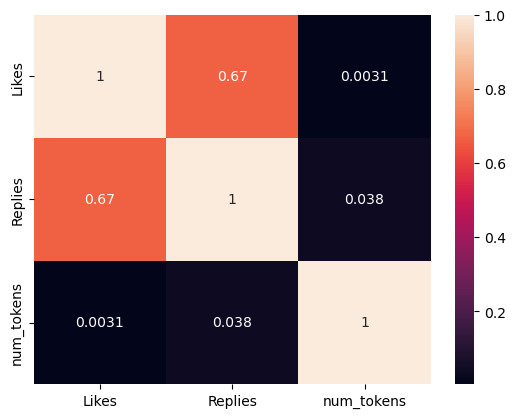

In [16]:
# Correlation matrix
numeric_data = dataset.select_dtypes(include=['number'])
corr = numeric_data.corr()
sns.heatmap(corr, annot=True)
plt.show()

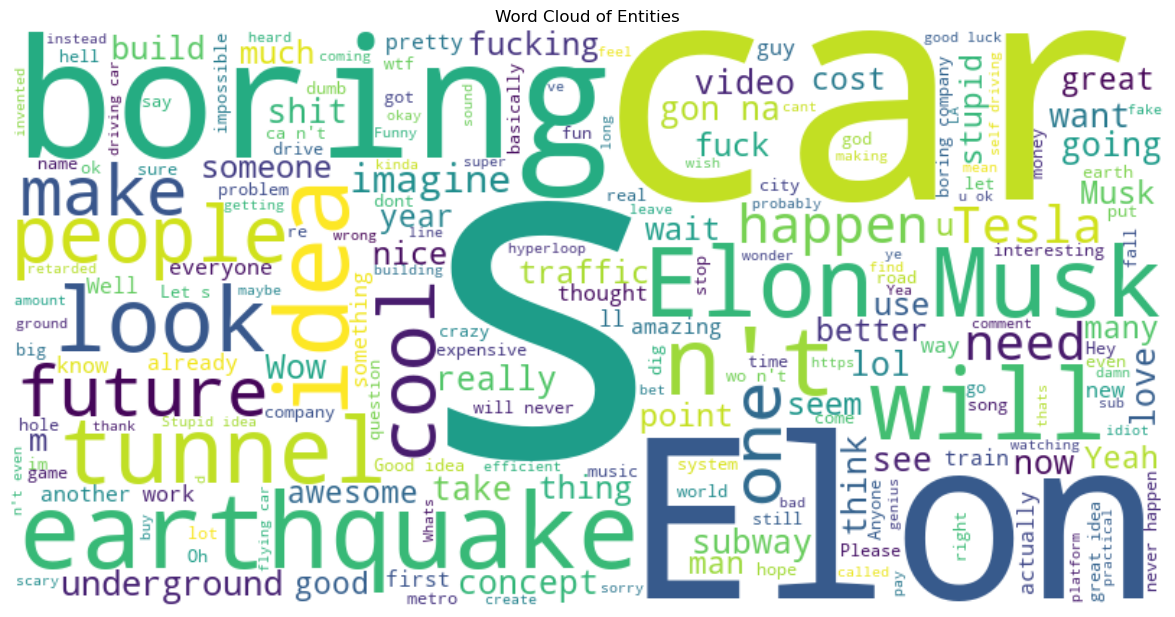

In [17]:
# Word cloud
# Create a word cloud using only tokens that are entities.
entity_tokens = [token for tokens, labels in zip(dataset['tokens'], dataset['labels'])
                 for token, label in zip(tokens, labels) if label != 'O']
dataset["entity_tokens"] = str(entity_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(entity_tokens))

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Entities')
plt.show()

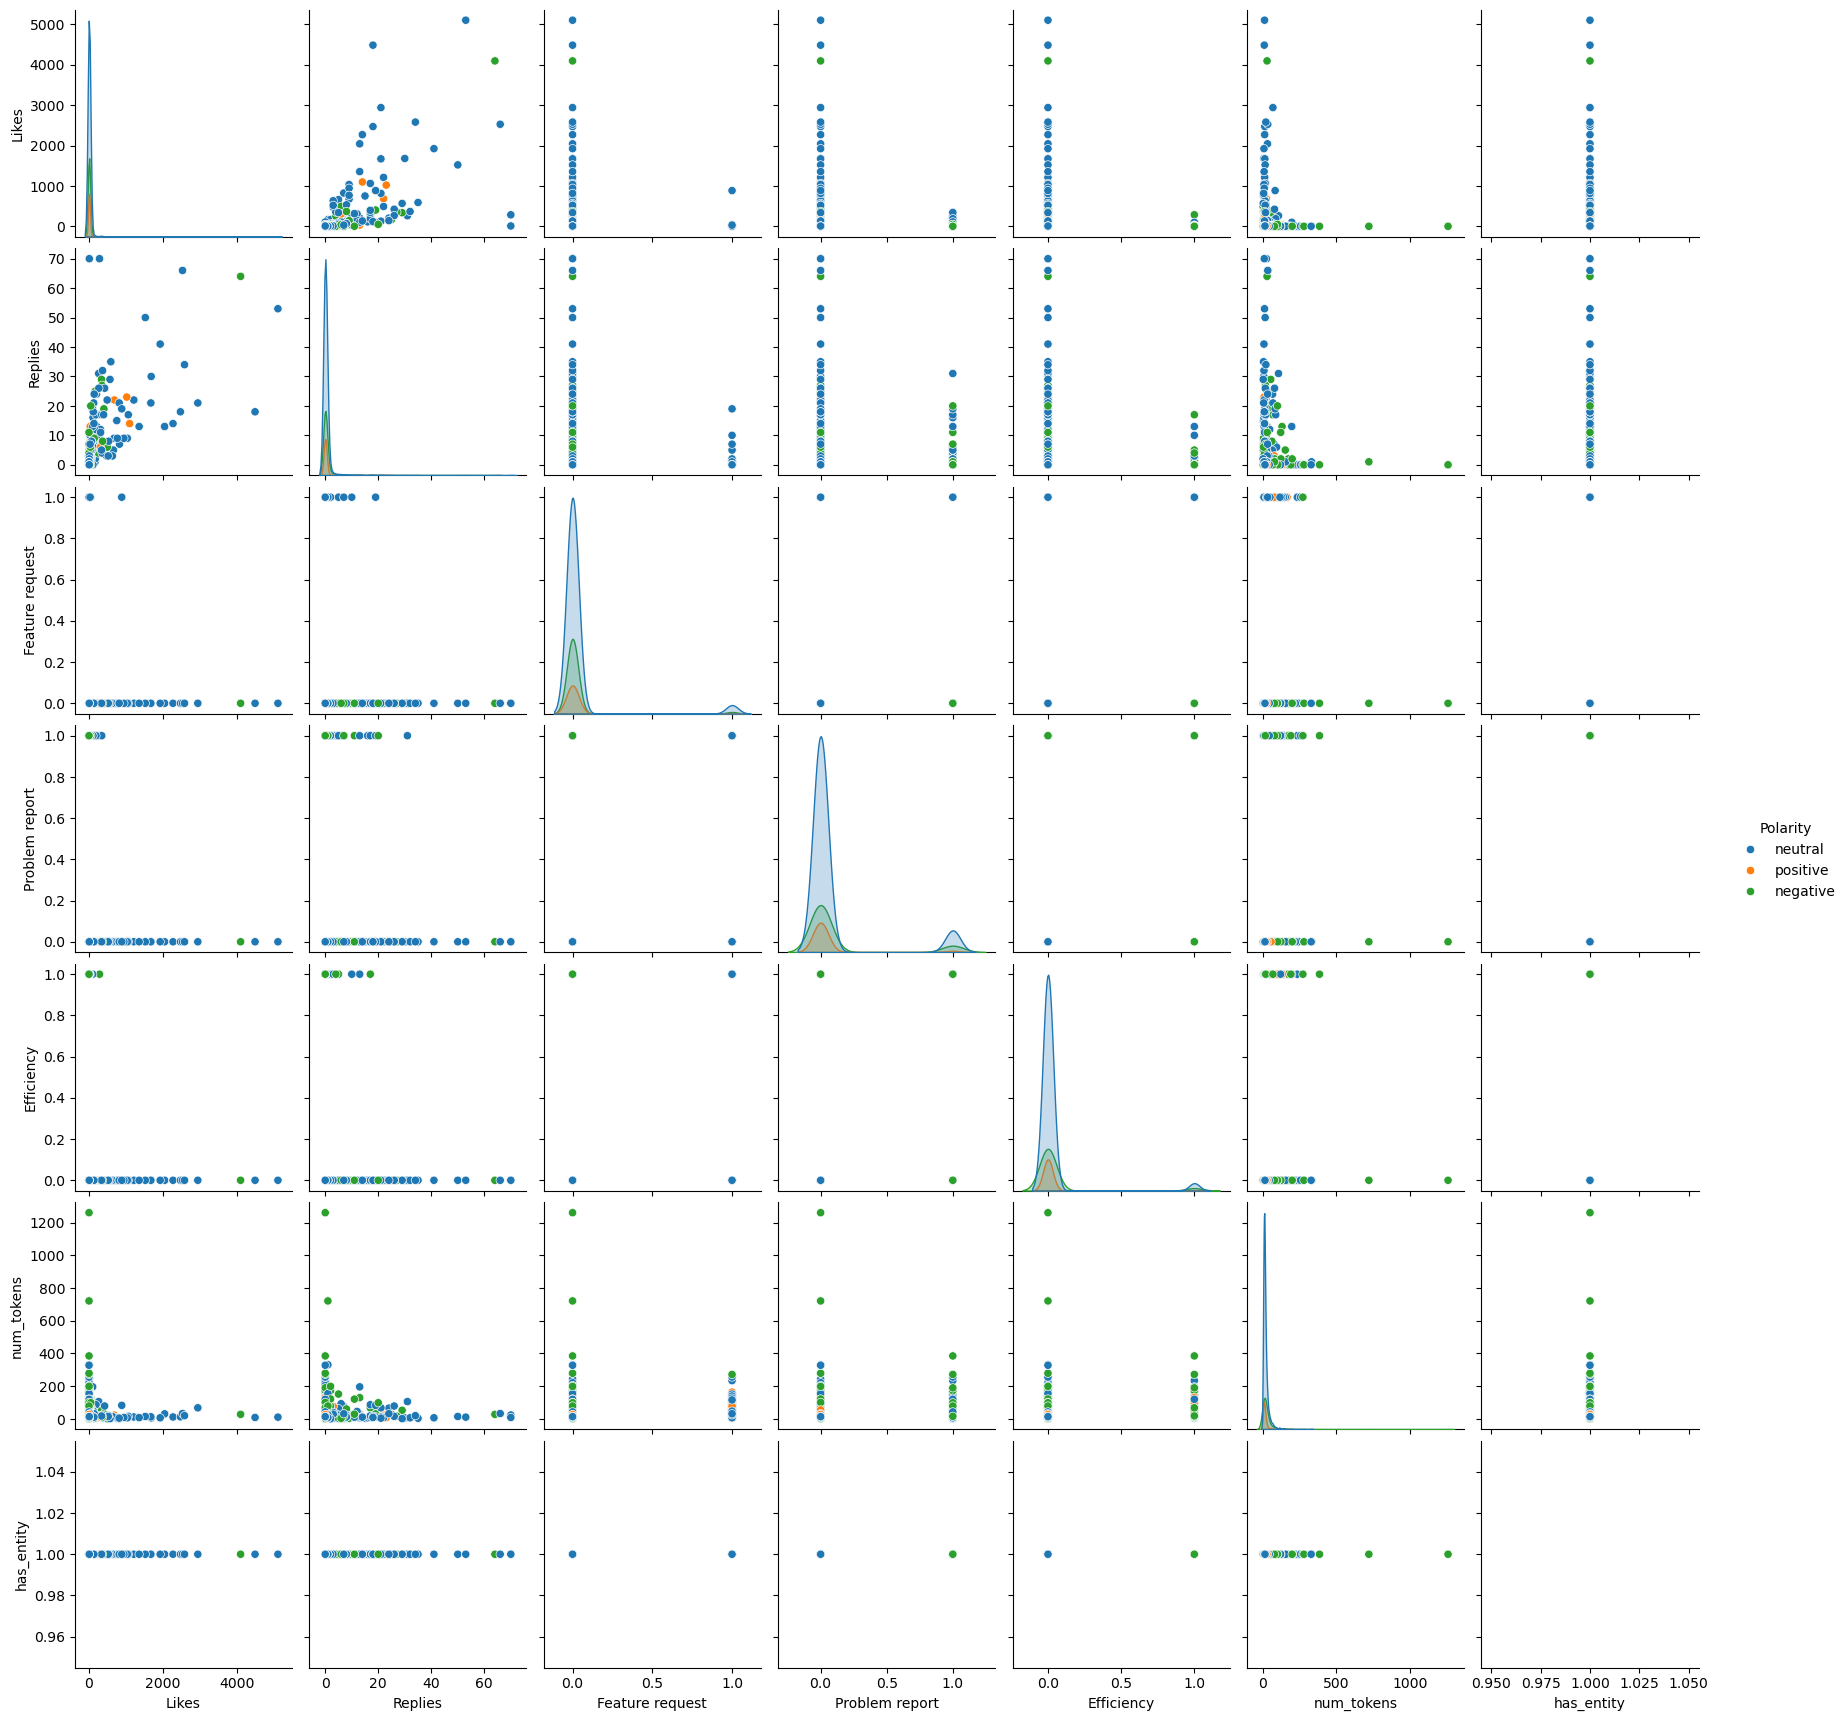

In [18]:
# Data visualization - pairplot
sns.pairplot(dataset, hue='Polarity')
plt.show()

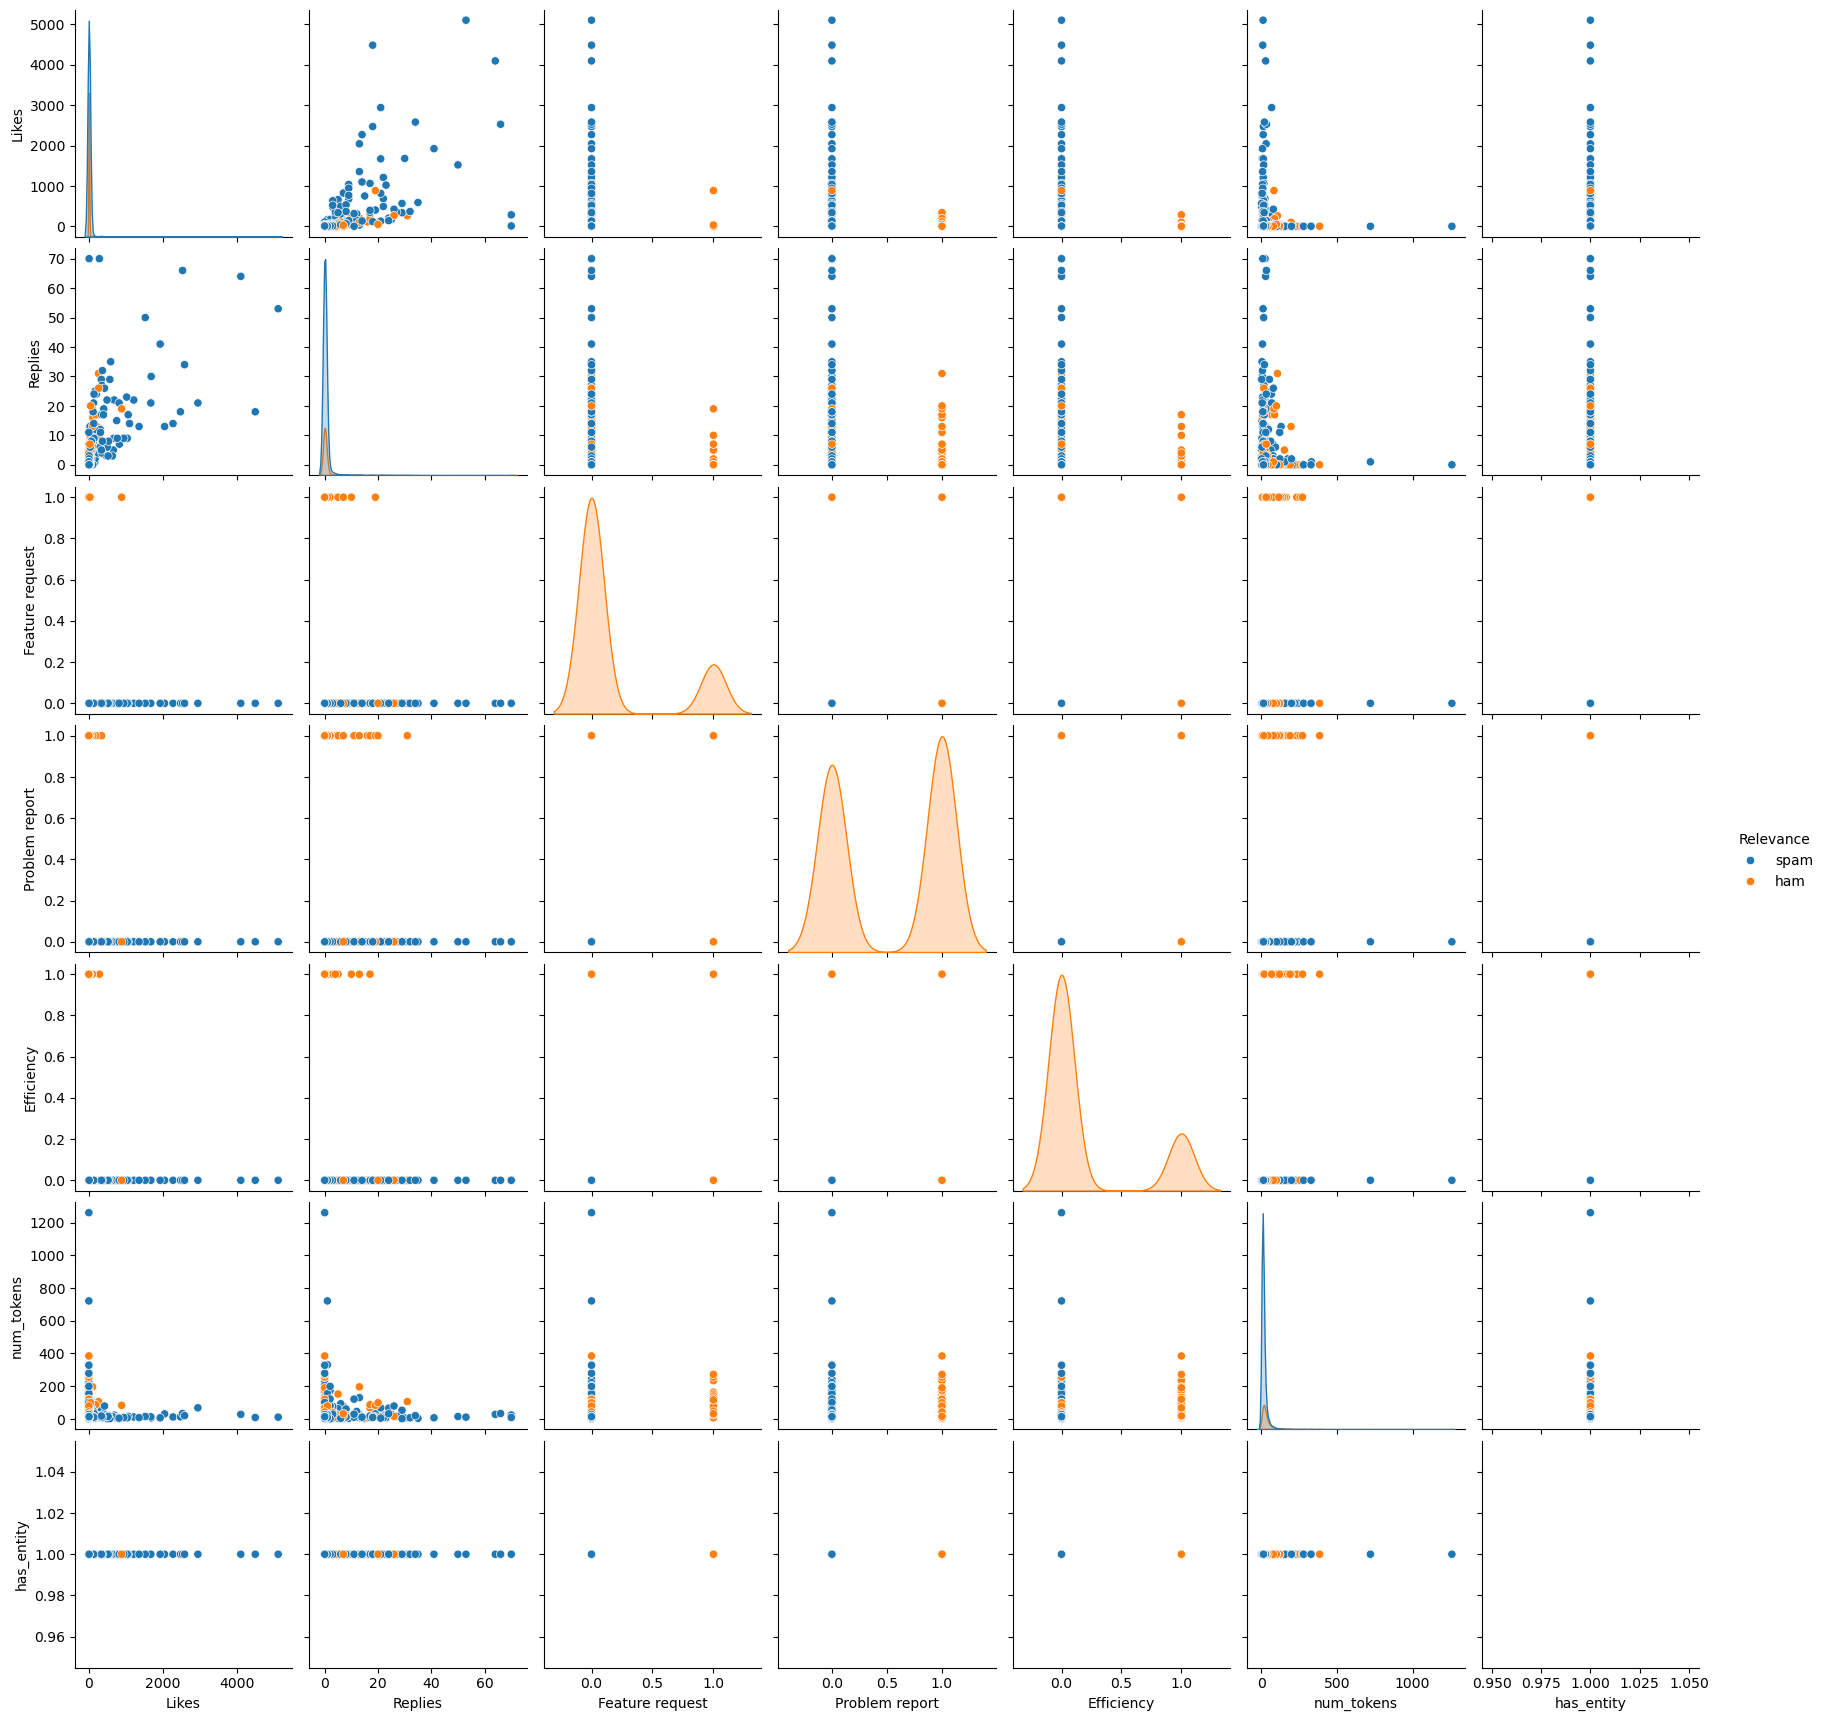

In [19]:
sns.pairplot(dataset, hue='Relevance')
plt.show()

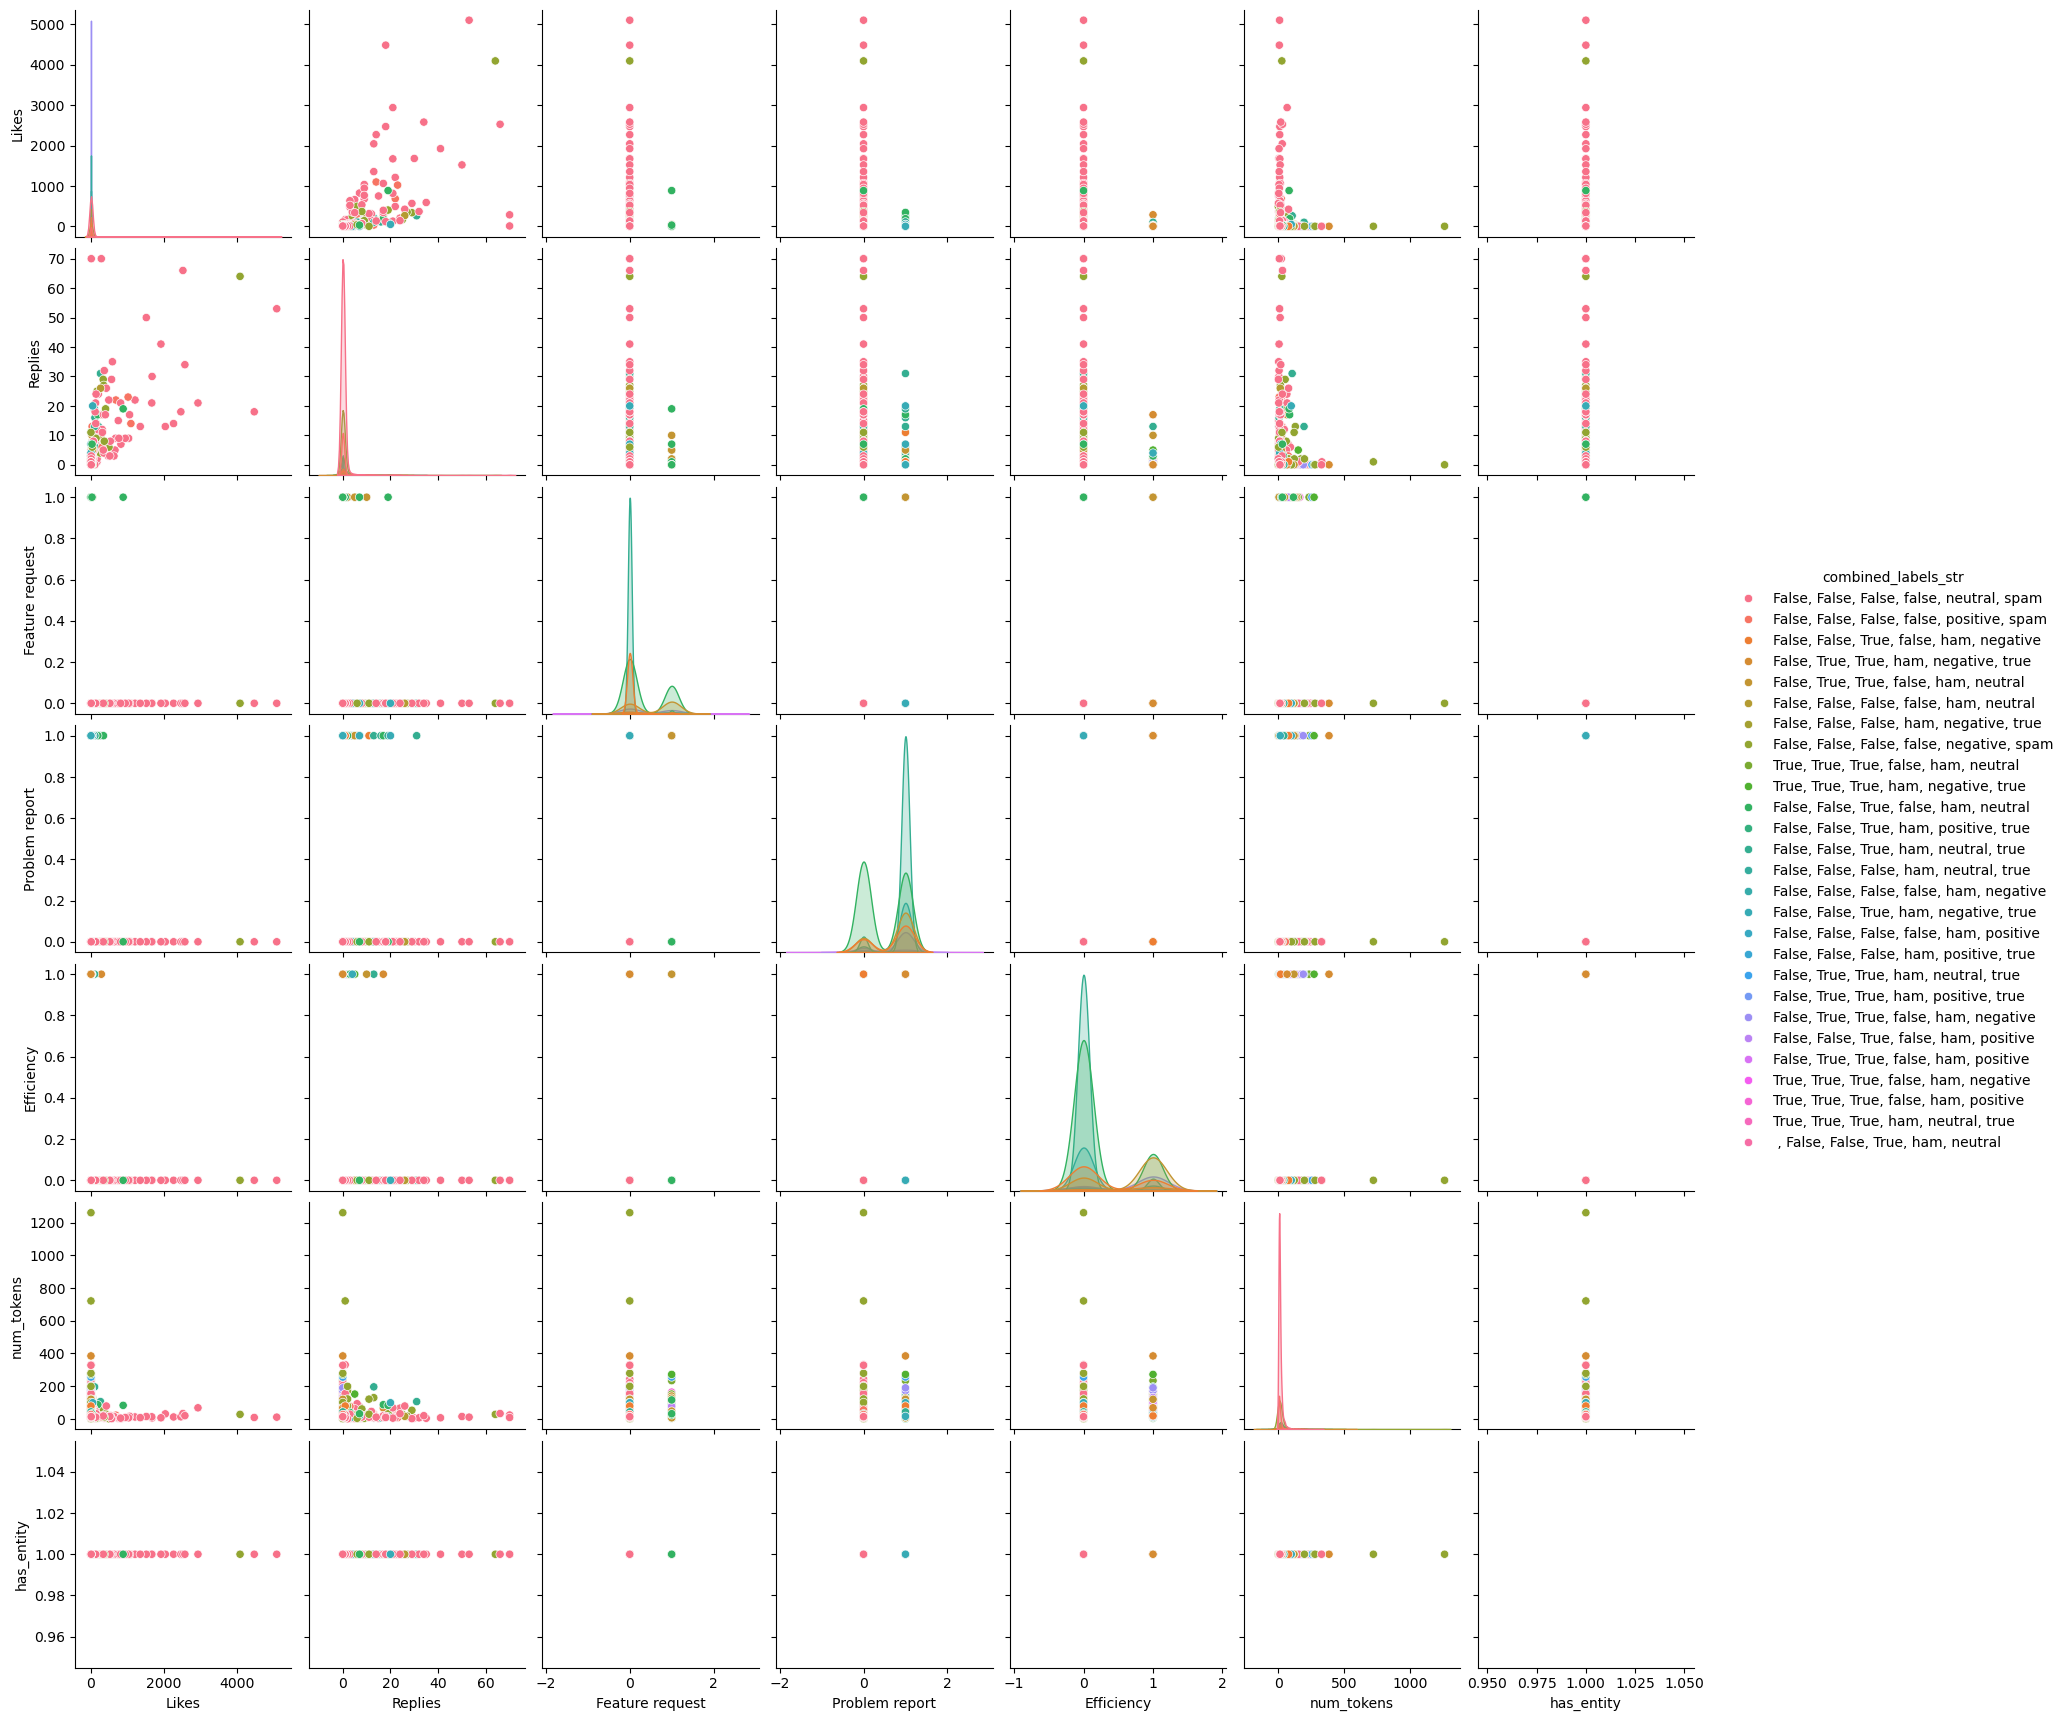

In [20]:
# Create a new column that joins multi-label lists into a single string.
# Sorting ensures consistent ordering.
dataset['combined_labels_str'] = dataset['labels'].apply(
    lambda labels: ", ".join(sorted([str(x) for x in labels])) if isinstance(labels, list) else labels
)

# Now use this combined column as the hue in your pairplot.
sns.pairplot(dataset, hue='combined_labels_str')
plt.show()

### Next Steps

1. Data Preparation:
- Tokenize comments and prepare multi-label columns.
- Combine or binarize labels as needed.
2. Model Training:
- Train a context-enriched NER or classification model on your prepared dataset.
3. Evaluation:
- Use the evaluation code above to measure performance.
4. Analysis & Tuning:
- Perform error analysis and adjust your model or feature extraction.
- Use visualization to further explore the data.
5. Trend Extraction:
- Apply clustering or topic modeling on the predicted labels or embeddings to identify emerging trends.

In [21]:
# Save the updated dataset to a new CSV file
dataset.to_csv('../data/4698969/Dataset_updated.csv', index=False)